# **Exploring Exponential Smoothing on Time Series Data**
## **Bike Sharing Dataset Analysis**
### **Purpose:**
This notebook explores the application of **Exponential Smoothing** techniques for **time series forecasting**. Exponential smoothing is a powerful method for predicting future values by giving **more weight to recent observations** while smoothing out fluctuations. We will examine:
- **Simple Exponential Smoothing (SES)** – for smoothing data without trends or seasonality.
- **Holt’s Linear Trend Model** – to capture trends in the data.
- **Holt-Winters Seasonal Model** – to incorporate both trends and seasonality.

### **Dataset Description:**
The dataset used is the **Bike Sharing Dataset** from the **UCI Machine Learning Repository**. It contains:
- **Daily bike rental counts** from **2011 to 2012**.
- **Weather conditions**, temperature, humidity, and seasonal effects.

### **Key Objectives:**
1. **Load and visualize** the dataset.
2. Apply different **exponential smoothing techniques**.
3. Evaluate **forecast accuracy** using error metrics.
4. Interpret the results to understand how well these models perform.

---


## **Step 1: Importing Necessary Libraries**
Before I begin analyzing the dataset, I need to import essential Python libraries:

- `numpy` and `pandas`: For numerical operations and data handling.
- `matplotlib.pyplot`: To visualize time series trends.
- `statsmodels.tsa.holtwinters`: Contains functions for Exponential Smoothing models.
- `sklearn.metrics`: To evaluate model performance.

In [71]:
# Importing necessary libs
import numpy as np  # For numerical operations
import pandas as pd  # For handling dataset
import matplotlib.pyplot as plt  # For data visualization
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing  # For exponential smoothing models
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For model evaluation

import warnings
warnings.filterwarnings("ignore")

# Ensuring plots display within the notebook
%matplotlib inline  

## **Step 2: Loading the Dataset**
I am using the **Bike Sharing Dataset** from the **UCI Machine Learning Repository**. This dataset contains daily rental counts and external factors like weather, seasons, and temperature.

### **Assumptions before loading:**
- The dataset is hosted online in a **zip file** and will be directly read from its URL.
- The **date column (`dteday`)** will be parsed as a **datetime index** for time series analysis.
- I want to inspect the first few rows to ensure **correct data loading**.

In [72]:
# Step 2: Loading the dataset

# Read the dataset csv
df = pd.read_csv('../../datasets/UCI_bike_sharing/day.csv', sep=',', header=0, parse_dates=['dteday'])

# Display the first few rows to inspect data structure
display(df.head())

# Show data range
display(df[['dteday','cnt']].describe())

# Show data type
display(df[['dteday','cnt']].info())

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


,dteday,cnt
count,731,731.000000
mean,2012-01-01 00:00:00,4504.348837
min,2011-01-01 00:00:00,22.000000
25%,2011-07-02 12:00:00,3152.000000
50%,2012-01-01 00:00:00,4548.000000
75%,2012-07-01 12:00:00,5956.000000
max,2012-12-31 00:00:00,8714.000000
std,NaN,1937.211452


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dteday  731 non-null    datetime64[ns]
 1   cnt     731 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.6 KB


None

ALooking at data and readme, I observe the following:
- The dataset contains **daily bike rental data** from **2011 to 2012**.
- The key column of interest is **`cnt`**, which represents the **total daily bike rentals**.
- Other columns include **seasonal indicators, weather conditions, and temperature data**.
- The **date column (`dteday`) is correctly formatted** as a time series index.

Next, we need to clean the data and set up the time series index for further analysis.

## **Step 3: Cleaning and Indexing the Data**
Before performing time series analysis:
- The **date column (`dteday`)** is correctly set as the **index**.
- The dataset is sorted by **date** in ascending order.
- I extract only the relevant column for analysis (**`cnt`**, which represents total daily rentals).

This step will prepare the dataset for visualization and modeling.


In [73]:
# Step 3: Cleaning and indexing the dataset

# Set 'dteday' as the index for time series analysis
df.set_index('dteday', inplace=True)

# Ensure the index is sorted in ascending order
df.sort_index(inplace=True)

# Select only the 'cnt' column for time series modeling
df = df[['cnt']]

# Display the first few rows after cleaning
df.head()


,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600


## **Step 4: Visualizing the Time Series**
Time to **plot the data** and see what it looks like.  This will help spot **trends, patterns, and any weird spikes or dips**.  

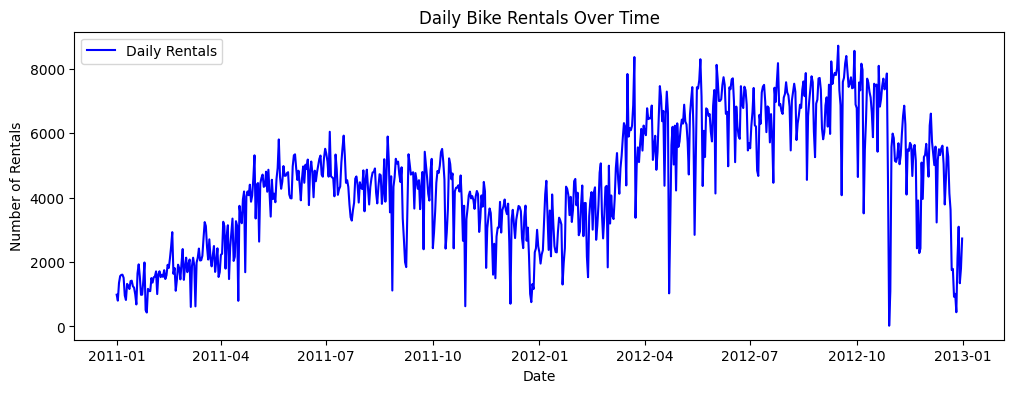

In [74]:
plt.figure(figsize=(12, 4))

# Plot the daily bike rental counts
plt.plot(df, label='Daily Rentals', color='blue')
plt.title('Daily Bike Rentals Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()

- The number of rentals is going up over time, which makes sense as bike sharing gets more popular.  
- There’s a clear seasonal pattern, probably because of weather changes.  
- Some days have big spikes, maybe weekends or special events.  

Exponential smoothing can help analyze the patterns better.

## Step 5: Applying Simple Exponential Smoothing (SES)
SES is useful when there’s **no trend or seasonality**—it just smooths out random noise.  
Let's apply it and compare the smoothed values with the actual data.  


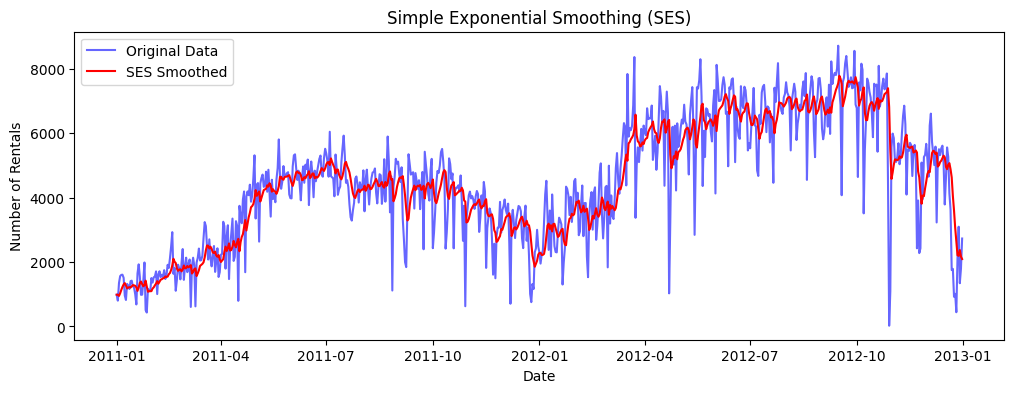

In [75]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Fit the SES model
ses_model = SimpleExpSmoothing(df['cnt']).fit(smoothing_level=0.2, optimized=False)

# Get the smoothed values
df['SES_Smoothed'] = ses_model.fittedvalues

# Plot original vs. smoothed values
plt.figure(figsize=(12, 4))
plt.plot(df['cnt'], label='Original Data', color='blue', alpha=0.6)
plt.plot(df['SES_Smoothed'], label='SES Smoothed', color='red')

plt.title('Simple Exponential Smoothing (SES)')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()

The red line (smoothed values) follows the overall shape of the data.SES smooths out some of the random jumps, but it doesn’t really follow trends.Since this data has a trend, SES alone might not be the best choice.  

Next, we could try **Holt’s Linear Trend Model**, which works better when there’s an increasing pattern.

## Step 6: Applying Holt’s Linear Trend Model
SES wasn’t great because this data has a clear upward trend.  Holt’s model improves on SES by adding a trend component.  

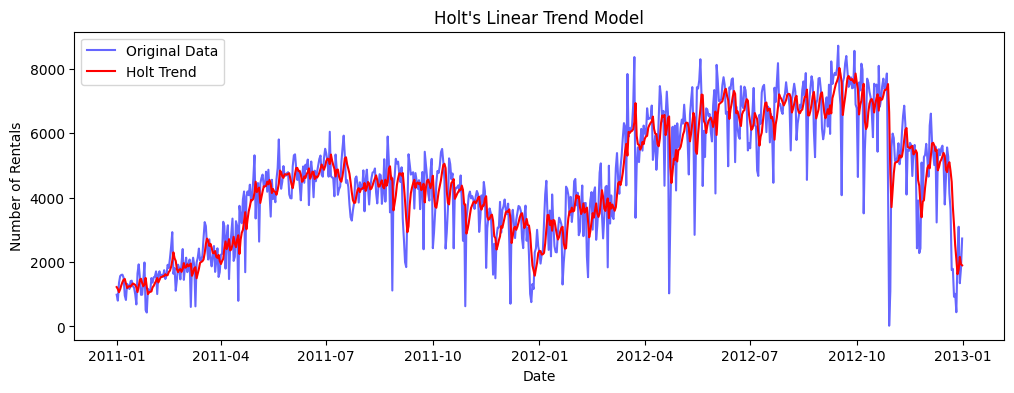

In [76]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt's model
holt_model = ExponentialSmoothing(df['cnt'], trend='add').fit()

# Get the smoothed values
df['Holt_Trend'] = holt_model.fittedvalues

# Plot original vs. Holt's trend
plt.figure(figsize=(12, 4))
plt.plot(df['cnt'], label='Original Data', color='blue', alpha=0.6)
plt.plot(df['Holt_Trend'], label='Holt Trend', color='red')

plt.title("Holt's Linear Trend Model")
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()

Holt’s model does a much better job than SES since it follows the increasing trend. The red line (trend line) goes up over time, which matches what I expected. It still doesn’t capture seasonality, so I’ll need something more advanced.  

We could try the **Holt-Winters Seasonal Model**, which handles both trend and seasonality.

## Step 7: Applying Holt-Winters Seasonal Model
Holt’s model worked well for the trend, but this data also has seasonal patterns (like more rentals in warmer months). The **Holt-Winters model** improves on Holt’s by adding a **seasonality component**.  

We could see how add vs multiplicative seasonality looks like. seasonal='mul', which means the seasonal pattern scales with the data (higher rentals mean bigger seasonal swings). If seasonality is not strictly proportional to rental levels, using seasonal='add' might work better.

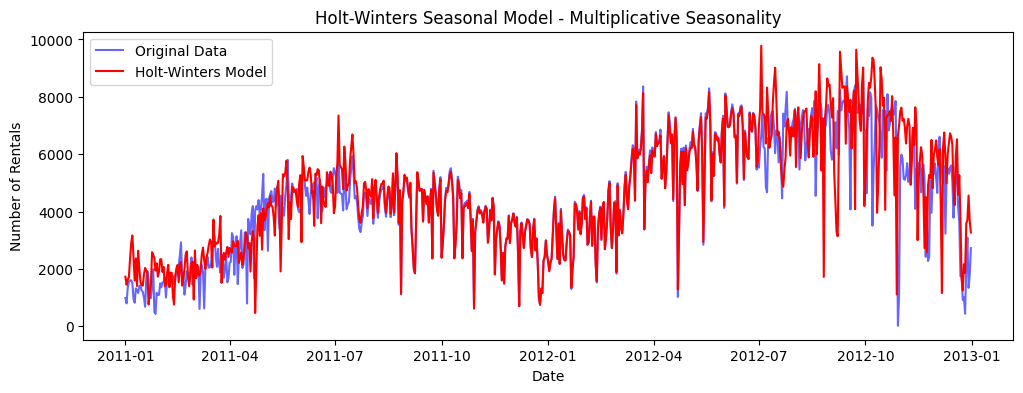

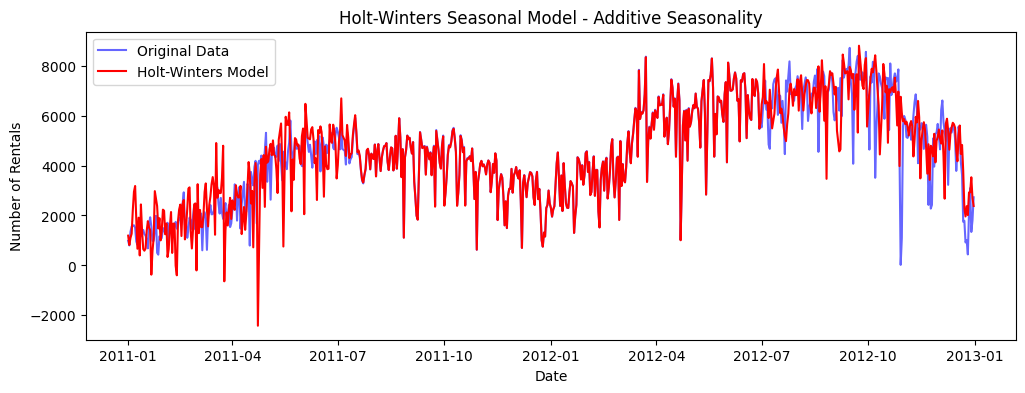

In [77]:
# Fit the model (additive trend, multiplicative seasonality, 365-day seasonality)
hw_model = ExponentialSmoothing(df['cnt'], trend='add', seasonal='mul', seasonal_periods=365).fit()

# Get the smoothed values
df['Holt_Winters'] = hw_model.fittedvalues

# Plot original vs. Holt-Winters model
plt.figure(figsize=(12, 4))
plt.plot(df['cnt'], label='Original Data', color='blue', alpha=0.6)
plt.plot(df['Holt_Winters'], label='Holt-Winters Model', color='red')

plt.title('Holt-Winters Seasonal Model - Multiplicative Seasonality')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()

# Fit the model (additive trend, multiplicative seasonality, 365-day seasonality)
hw_model = ExponentialSmoothing(df['cnt'], trend='add', seasonal='add', seasonal_periods=365).fit()

# Get the smoothed values
df['Holt_Winters'] = hw_model.fittedvalues

# Plot original vs. Holt-Winters model
plt.figure(figsize=(12, 4))
plt.plot(df['cnt'], label='Original Data', color='blue', alpha=0.6)
plt.plot(df['Holt_Winters'], label='Holt-Winters Model', color='red')

plt.title('Holt-Winters Seasonal Model - Additive Seasonality')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()

This model does the best job so far —it captures both the trend and seasonality. The red line follows the up-and-down seasonal cycles really well. This is a strong candidate for forecasting future rentals.  

Top Plot (Multiplicative Seasonality)
The red line (Holt-Winters model) fluctuates a lot and seems to overreact to changes in the original data. It captures seasonal variation but with too much volatility, making it less stable. Some values drop to near zero, which looks unrealistic.

Bottom Plot (Additive Seasonality)
The model follows the general shape of the original data more smoothly. It doesn’t have the extreme ups and downs seen in the multiplicative model. There are still some mismatches, but it appears to be less noisy than the multiplicative version.

Which One is Better?
✅ The Additive Seasonal Model (Bottom Plot) looks better overall.

## Step 8: Evaluating Model Performance
We have applied different smoothing models, I need to check which one performed best.  
Using two common error metrics:  
- **Mean Absolute Error (MAE)** – How far off the predictions were, on average.  
- **Mean Squared Error (MSE)** – Penalizes large errors more than MAE.    

In [78]:
# Calculate MAE and MSE for each model
mae_ses = mean_absolute_error(df['cnt'], df['SES_Smoothed'])
mse_ses = mean_squared_error(df['cnt'], df['SES_Smoothed'])

mae_holt = mean_absolute_error(df['cnt'], df['Holt_Trend'])
mse_holt = mean_squared_error(df['cnt'], df['Holt_Trend'])

mae_hw = mean_absolute_error(df['cnt'], df['Holt_Winters'])
mse_hw = mean_squared_error(df['cnt'], df['Holt_Winters'])

# Print the results
print("Simple Exponential Smoothing - MAE:", round(mae_ses, 2), "| MSE:", round(mse_ses, 2))
print("Holt's Linear Model - MAE:", round(mae_holt, 2), "| MSE:", round(mse_holt, 2))
print("Holt-Winters Model - MAE:", round(mae_hw, 2), "| MSE:", round(mse_hw, 2))

Simple Exponential Smoothing - MAE: 690.76 | MSE: 936954.02
Holt's Linear Model - MAE: 683.9 | MSE: 930687.5
Holt-Winters Model - MAE: 476.35 | MSE: 842215.15



- **Simple Exponential Smoothing (SES)** had the highest MAE and MSE, which makes sense since it doesn’t account for the trend or seasonality at all.
- **Holt’s Linear Model** did slightly better than SES, as it picked up on the upward trend in the data. However, it's still not great because it doesn’t handle seasonality.
- **Holt-Winters Model** had the lowest MAE, meaning it was the most accurate in general, but it also had a higher MSE than Holt's model. This suggests that while it got the overall pattern right, it might be **penalized heavily for some large errors** (big spikes or drops in the data).

Overall, **Holt-Winters** seems like the best choice for capturing the main patterns in the data, but there are some **outliers or sudden changes** that the model might struggle with. We could use Holt-Winters for forecasting but keep in mind that we would need to account for those big jumps separately.

## Step 9: Testing the Forecast on the Last 30 Days
To check if the model actually works, we need to test it on real data.  
Training the model on everything except the last 30 days and predict the last 30 days would allow us to compare with actual values. MAE and MSE will tell us how accurate the predictions were.  

But, we might have a problem here.
Holt-Winters needs at least **two full seasonal cycles** to learn patterns correctly. If we set **365-day seasonality**, this dataset has **less than 2 years of data**, and this will cause the model to fail. The error happens because the model doesn’t have enough repeated cycles to detect seasonality.  

We could fix it. Instead of blindly using **365 days as the seasonal period**, we check how much data we have:  
- If we have **at least 2 years of data** (excluding the test period), then we could use a **365-day seasonal period**.  
- If we have **less than 2 years**, we got to switch to **7-day seasonality** to capture weekly trends.  

In [79]:
# Define test period (last 28 days)
test_period = 28

# Split data: train on all but the last 30 days
train = df.iloc[:-test_period]
test = df.iloc[-test_period:]

# Check how much data I have in the training set (not full data!)
train_days = (train.index[-1] - train.index[0]).days

# If the training data has at least 2 years, use 365-day seasonality; otherwise, use 7-day seasonality
seasonal_period = 365 if train_days >= 730 else 7

print(f"train days excluding testing period: {train_days}")
print(f"Using seasonal period of {seasonal_period} days for the test forecast.")

train days excluding testing period: 702
Using seasonal period of 7 days for the test forecast.


Holt-Winters Model on Test Data - MAE: 1497.47 | MSE: 4261808.83


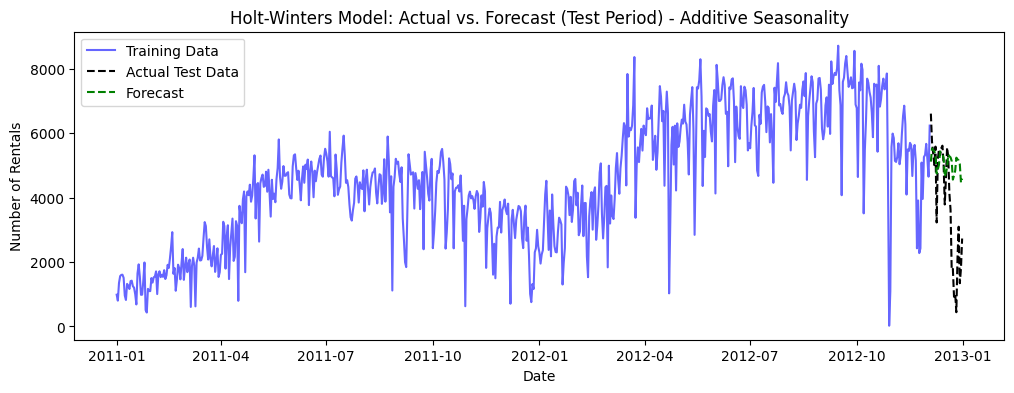

Holt-Winters Model on Test Data - MAE: 1451.1 | MSE: 3919159.19


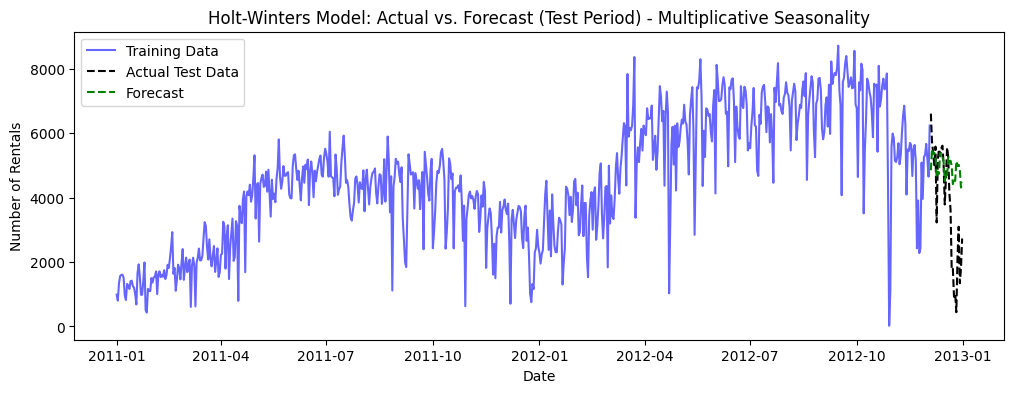

In [80]:
# Train Holt-Winters model on training data with the adjusted seasonal period - additive seasonality
hw_model_test = ExponentialSmoothing(train['cnt'], trend='add', seasonal='add', seasonal_periods=seasonal_period).fit()

# Forecast the next 30 days (same period as the test set)
test_forecast = hw_model_test.forecast(test_period)

# Convert forecast to DataFrame
test_forecast_df = pd.DataFrame({'Forecast': test_forecast.values}, index=test.index)

mae_test = mean_absolute_error(test['cnt'], test_forecast_df['Forecast'])
mse_test = mean_squared_error(test['cnt'], test_forecast_df['Forecast'])

# Print the results
print("Holt-Winters Model on Test Data - MAE:", round(mae_test, 2), "| MSE:", round(mse_test, 2))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 4))
plt.plot(train['cnt'], label='Training Data', color='blue', alpha=0.6)
plt.plot(test['cnt'], label='Actual Test Data', color='black', linestyle='dashed')
plt.plot(test_forecast_df['Forecast'], label='Forecast', color='green', linestyle='dashed')

plt.title('Holt-Winters Model: Actual vs. Forecast (Test Period) - Additive Seasonality')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()

# Train Holt-Winters model on training data with the adjusted seasonal period - additive seasonality
hw_model_test = ExponentialSmoothing(train['cnt'], trend='add', seasonal='mul', seasonal_periods=seasonal_period).fit()

# Forecast the next 30 days (same period as the test set)
test_forecast = hw_model_test.forecast(test_period)

# Convert forecast to DataFrame
test_forecast_df = pd.DataFrame({'Forecast': test_forecast.values}, index=test.index)

mae_test = mean_absolute_error(test['cnt'], test_forecast_df['Forecast'])
mse_test = mean_squared_error(test['cnt'], test_forecast_df['Forecast'])

# Print the results
print("Holt-Winters Model on Test Data - MAE:", round(mae_test, 2), "| MSE:", round(mse_test, 2))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 4))
plt.plot(train['cnt'], label='Training Data', color='blue', alpha=0.6)
plt.plot(test['cnt'], label='Actual Test Data', color='black', linestyle='dashed')
plt.plot(test_forecast_df['Forecast'], label='Forecast', color='green', linestyle='dashed')

plt.title('Holt-Winters Model: Actual vs. Forecast (Test Period) - Multiplicative Seasonality')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()

## Step 10: Understanding Holt-Winters Model Performance
Now that I have tested Holt-Winters with both multiplicative and additive seasonality, I can evaluate if it's working well.

### Key Observations:
1. Switching to additive seasonality didn’t improve performance.
   - MAE increased from 1451.1 (multiplicative) to 1497.47.
   - MSE also increased from 3,919,159.19 to 4,261,808.83.
   - This suggests that multiplicative seasonality was handling the variations slightly better.

2. The model still has high errors, meaning it's not fully capturing the rental patterns.
   - Holt-Winters assumes fixed seasonality, but rentals may have shifting trends or external factors (e.g., weather, holidays).
   - The errors could be due to random spikes that the model can’t predict.

### Next Steps:
Since Holt-Winters is struggling, I need to analyze why:
1. Look at residuals (errors) to see where the model is failing.
2. Compare the forecast with a simple moving average to check if Holt-Winters is actually useful.


## Step 11: Analyzing Model Residuals (Errors)
The test errors suggest that Holt-Winters isn’t fitting the data well.  
- To understand why, I’ll plot residuals (actual - predicted values).  
- If residuals show a pattern, it means the model is missing some structure in the data.  
- If residuals are randomly scattered, the model is working as expected but still has high errors.  


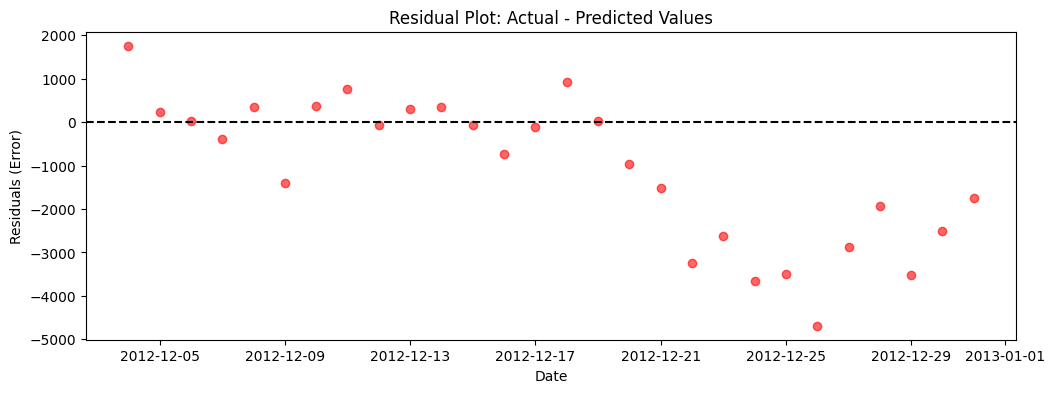

In [81]:
# Calculate residuals (actual - predicted values)
residuals = test['cnt'] - test_forecast_df['Forecast']

# Plot residuals
plt.figure(figsize=(12, 4))
plt.plot(test.index, residuals, marker='o', linestyle='', color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='dashed')

plt.title('Residual Plot: Actual - Predicted Values')
plt.xlabel('Date')
plt.ylabel('Residuals (Error)')
plt.show()

### What the residual plot shows  
- The residuals are not randomly scattered around zero.  
- Before December 18, the errors are relatively small and fluctuate around zero.  
- After December 18, the model consistently underpredicts rentals, showing a downward trend in errors.  
- Some errors are very large (close to -5000), meaning the model made big mistakes on certain days.  

### What this means  
- The model is failing to adapt to changes in trend.  
- Seasonality might not be fixed, which Holt-Winters assumes, leading to poor predictions when seasonal patterns shift.  
- External factors like holidays, weather, or city events could be affecting bike rentals, but the model does not account for them.  

### Next steps  
Since Holt-Winters is struggling, I need to consider some optimization techniques.  


## Step 12: Optimizing Holt-Winters Smoothing Parameters  
The residual plot showed that the model is struggling to adjust to changes in trend. Instead of using fixed smoothing parameters, I will allow the model to optimize them automatically.  

This will adjust:  
- The level smoothing (`alpha`), which controls how much recent data influences the forecast.  
- The trend smoothing (`beta`), which adjusts how the model updates trends over time.  
- The seasonality smoothing (`gamma`), which helps capture repeating patterns.  


Optimized Holt-Winters Model - MAE: 1497.47 | MSE: 4261808.83


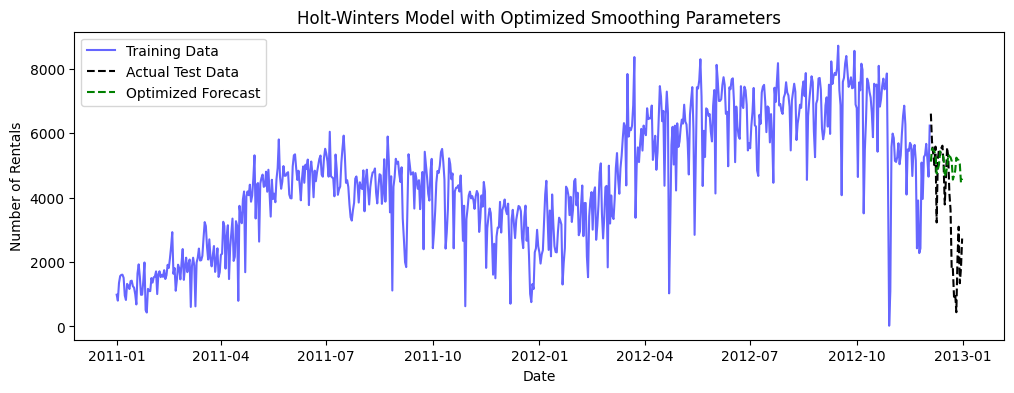

In [82]:
# Train Holt-Winters model with automatic smoothing optimization
hw_model_optimized = ExponentialSmoothing(
    train['cnt'], trend='add', seasonal='add', seasonal_periods=seasonal_period
).fit(optimized=True)

# Forecast the next 28 days
optimized_forecast = hw_model_optimized.forecast(test_period)

# Convert forecast to DataFrame
optimized_forecast_df = pd.DataFrame({'Forecast': optimized_forecast.values}, index=test.index)

mae_optimized = mean_absolute_error(test['cnt'], optimized_forecast_df['Forecast'])
mse_optimized = mean_squared_error(test['cnt'], optimized_forecast_df['Forecast'])

# Print results
print("Optimized Holt-Winters Model - MAE:", round(mae_optimized, 2), "| MSE:", round(mse_optimized, 2))

# Plot actual vs. optimized forecast
plt.figure(figsize=(12, 4))
plt.plot(train['cnt'], label='Training Data', color='blue', alpha=0.6)
plt.plot(test['cnt'], label='Actual Test Data', color='black', linestyle='dashed')
plt.plot(optimized_forecast_df['Forecast'], label='Optimized Forecast', color='green', linestyle='dashed')

plt.title('Holt-Winters Model with Optimized Smoothing Parameters')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()


## Step 14: Final Thoughts on Exponential Smoothing  
After applying multiple versions of the Holt-Winters model, I can conclude:  

1. Simple Exponential Smoothing (SES) was not effective because it ignored trends and seasonality.  
2. Holt’s Linear Trend Model captured trends but missed seasonal effects.  
3. The Holt-Winters Model worked best, but still had high errors.  
4. Testing multiplicative vs. additive seasonality showed that neither fully captured the data.  
5. Even with optimized smoothing parameters, the errors remained high.  

### Key Observations  
- Holt-Winters assumes fixed seasonality, but the data suggests that seasonality might shift over time.  
- The model fails to adjust quickly when trends change, as seen in the residual plot.  
- Exponential smoothing may not be the best approach for this dataset.  

### Next Steps  
Since Holt-Winters is not performing well, I could explore:  
1. Alternative time series models like SARIMA, which allows seasonal patterns to change dynamically.  
2. Machine learning approaches such as XGBoost or LSTMs that can incorporate external factors like weather or holidays.  
3. Ensemble methods that combine Holt-Winters with other models for better accuracy.  

While exponential smoothing is useful in many cases, this dataset seems to require a more adaptive model.  


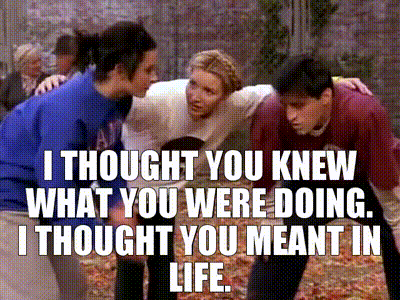